# Definición del Objetivo
A continuación, se hará un análisis exploratorio del conjunto de datos que corresponde a la Encuesta Nacional Urbana de Seguridad Ciudadana (ENUSC). 

¿Qué es la ENUSC? (Según ellos mismos): _"Desde el año 2003, el INE, a través de un convenio con la Subsecretaría de Prevención del Delito, realiza la Encuesta Nacional Urbana de Seguridad Ciudadana (ENUSC). Este estudio permite conoce la cantidad de personas y hogares que han sido víctima de delitos, así como la percepción de inseguridad en la población."_

En base a esa definición, nos propusimos desarrollar un modelo de aprendizaje automático que sea capaz de predecir la probabilidad de que un hogar sea víctima de un delito (en Chile). Una idea interesante de modelar en base a diversas características, tales como: económicas (el status de la familia del hogar), demograficas (¿Afectará la región en el cálculo de esta probabilidad?), del entorno, entre otras carácteristicas. 

Explorando el diccionario de variables, dimos con una característica llamada **VH_DMCS** la cual se define como: _"Victimización a hogares por delitos de mayor connotación social (Indicador de victimización histórico)"_. 
Es una variable binaria de dos clases: 
- 0: "No" -> el hogar no fue víctima.
- 1: "Sí" -> el hogar sí fue víctima. 

Lo que lo convierte en un candidato robusto para medir la seguridad del entorno, ya que agrupa los delitos más graves para la ciudadanía. Además, se puede considerar como una pregunta bastante general, lo que nos permite cruzarla con otras variables de caracterización y así obtener más datos útiles. 

Estas son las razones de elegir **VH_DMCS** como target, porque responde directamente a una pregunta importante de la encuesta: Entender qué factores se relacionan con el hecho de ser o no víctima de un delito. 

# Exploración de Datos

### Importación del dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df= pd.read_csv("../Data/base-de-datos---enusc-2024.csv", sep=';', decimal=',')

df.head()


,Unnamed: 0,rph_ID,idhogar,enc_idr,enc_region,IH_residencia_habitual,IH_comparte_gastos,IH_numero_grupos,IH_cantidad_hogar,rph_numeroLinea,...,AMEN_REGION,EXT_REGION,SOB_REGION,Fact_Pers_Reg,Fact_Hog_Reg,VarStrat,Conglomerado,com102,Fact_Hog_Regional_102,Fact_Pers_Regional_102
0,1,10001-1,10001-1,10001,8,1,NaN,NaN,1,1,...,NaN,NaN,NaN,229.898740,237.838487,2.024000e+09,2.024000e+13,1.0,260.552368,294.664390
1,2,10002-1,10002-1,10002,10,1,NaN,NaN,1,1,...,NaN,NaN,NaN,154.721281,183.351506,2.024000e+09,2.024000e+13,1.0,208.647186,228.040032
2,3,10003-1,10003-1,10003,8,2,1.0,NaN,1,1,...,NaN,NaN,NaN,460.038821,242.024680,2.024000e+09,2.024000e+13,1.0,293.256301,595.433674
3,4,10003-2,10003-1,10003,8,2,1.0,NaN,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,10004-1,10004-1,10004,10,1,NaN,NaN,1,1,...,NaN,NaN,NaN,154.531255,183.126317,2.024000e+09,2.024000e+13,1.0,208.339870,227.704152


### Descripción Estadística de variables

Se observan que hay solo 2 variables categoricas, lo cual no tiene mucho sentido, ya que por ejemplo; 
los ids, las regiones, nível socioeconómico, entre muchas otras son variables categoricas (objeto).

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70858 entries, 0 to 70857
Columns: 1314 entries, Unnamed: 0 to Fact_Pers_Regional_102
dtypes: float64(1299), int64(13), object(2)
memory usage: 710.4+ MB


In [3]:
# Calcular los cantidad de valores nulos: 
porcentaje_nulos = (df.isnull().sum() / len(df)) * 100

print("Top 20 columnas con más valores nulos:")
print(porcentaje_nulos.sort_values(ascending=False).head(20))

Top 20 columnas con más valores nulos:
VECINOS_ADOPTADAS_NA    100.000000
RFV_DONDE_COMUNA        100.000000
RFV_DONDE_REGION        100.000000
SOB_DENUNCIA_COMO       100.000000
SOB_SATISF_DEN          100.000000
SOB_CONTACTO_MP         100.000000
SOB_CONT_MP_MOT__1      100.000000
SOB_CONT_MP_MOT__88     100.000000
ADOPTADAS_NA            100.000000
SOB_CONT_MP_MOT__4      100.000000
VANDVIV_DONDE_REGION    100.000000
SOB_ACCION_POLICIAL     100.000000
SOB_CONT_MP_MOT__3      100.000000
SOB_CONT_MP_MOT__99     100.000000
SOB_DENUNCIAS_N         100.000000
SOB_CONT_MP_MOT__2      100.000000
SOB_CONT_MP_MOT__5      100.000000
SOB_DENUNCIA_FIRMA      100.000000
EXT_CONT_MP_MOT__2       99.998589
VANDVIV_DONDE_COMUNA     99.998589
dtype: float64


Un gran porcentaje de columnas con demasiados valores nulos, pero no es de extrañar, ya que existen preguntas que si se responden con un 'NO', entonces automáticamente se descartan una gran serie de preguntas subsiguientes. Resultando así en muchas columnas con valores nulos. 

In [4]:
columnas_nulas = sum(porcentaje_nulos > 50)
cant_columnas = len(df.columns)
print(f"Columnas con más del 50% de nulos: {columnas_nulas}")
print(f"Porcentaje de columnas con más de la mitad de datos nulos: {(columnas_nulas/cant_columnas) * 100:.3f}%")

Columnas con más del 50% de nulos: 1284
Porcentaje de columnas con más de la mitad de datos nulos: 97.717%


Como ya tenemos identificado el target, se puede realizar una limpieza relevante de datos, ya que ahora solo nos interesa el **'Informante Kish'**. 

Informante Kish: Es la persona representante del hogar en la encuesta. 

Es ésta la persona de interés, ya que responde a si el hogar fue víctima de delito. 

In [5]:
# Filtramos el DF para quedarnos solo con el "Informante Kish"
df_informantes = df[df['Kish'] == 1].copy()

print(f"Filas originales (personas): {len(df)}")
print(f"Filas filtradas (informantes): {len(df_informantes)}")

Filas originales (personas): 70858
Filas filtradas (informantes): 24472


Antes de comenzar a analizar, eliminamos variables que son consecuencia de delito para evitar fuga de datos. 

Ejemplo, si tenemos una variable que marca que una persona fue víctima de un robo de vehículo, nuestro modelo sabrá que entonces el target debe ser 1, lo cual no tiene mucho sentido para el objetivo de ésta tarea. 

In [6]:
def drop_victimization_features(df, target_variable='VH_DMCS'):
    # Prefijos asociados a la sección de victimización
    victimization_prefixes = [
        'SCREEN_', 'RDV_', 'RDDV_', 'VANDVHC_', 'RFV_', 'VANDVIV_', 'RVI_',
        'RPS_', 'HUR_', 'FRB_', 'EST_', 'AGR_', 'AMEN_', 'EXT_', 'SOB_',
        'HACK_', 'VIRUS_', 'BULLY_', 'SUPLANT_', 'ACOSO_', 
        'VH_', 'VH_DC', 'RDDV', 'HUR', 'VH_DV', 'RFV', 'RPS', 
        'VP', 'RVI', 'AGR', 'RDV', 'VH_IR', 'RVH', 'FILTRO_VEHIC', 'COSC',
        'DEN_', 'Kish', 'Hogar_Kish', 'Conglomerado', 'Varstrat', 'Fact_'
    ]
    
    cols_to_drop = []
    for col in df.columns:
        # Solo borra la columna si no es el target y empieza con un prefijo
        if col != target_variable and any(col.startswith(p) for p in victimization_prefixes):
            cols_to_drop.append(col)
    
    print(f"Se eliminarán {len(cols_to_drop)} columnas (se conserva el target '{target_variable}').")
    return df.drop(columns=cols_to_drop, errors='ignore')

df_informantes = drop_victimization_features(df_informantes, target_variable='VH_DMCS')

df_informantes.info()

Se eliminarán 1104 columnas (se conserva el target 'VH_DMCS').
<class 'pandas.core.frame.DataFrame'>
Index: 24472 entries, 0 to 70854
Columns: 210 entries, Unnamed: 0 to com102
dtypes: float64(197), int64(11), object(2)
memory usage: 39.4+ MB


En base a solo hipótesis y conocimiento de dominio, hacemos una selección de variables (inicial solamente, después más adelante se seleccionarán más). Seleccionamos 4 variables representativas para contrastar algunas de estas hipótesis. 

- Dimensión Geográfica (enc_region): La distribución del delito no es homogénea entre todas las regiones.

- Dimensión Socioeconómica (rph_nse): El nivel socioeconómico influye en la victimización, ya sea por la exposición al riesgo o por el atractivo de los bienes materiales del hogar.

- Dimensión Psicológica/Percepción (P_AUMENTO_BARRIO): Existe una correlación entre la realidad objetiva (ser víctima) y la subjetiva (sentir que la delincuencia aumenta).

- Dimensión Situacional/Preventiva (MEDIDAS_REJAS): La presencia de medidas de seguridad visibles (como rejas) podría tener una relación con la victimización.

In [7]:
# Mapeo para nuestra variable objetivo: Victimización (VH_DMCS)
victima_labels = {
    0: 'No víctima',
    1: 'Sí'
}
df_informantes['victima_label'] = df_informantes['VH_DMCS'].map(victima_labels)

# Mapeo para Nivel Socioeconómico (rph_nse)
nse_labels = {
    1: 'NSE bajo',
    2: 'NSE medio',
    3: 'NSE alto'
}
df_informantes['nse_label'] = df_informantes['rph_nse'].map(nse_labels)

# Mapeo para Percepción en Barrio (P_AUMENTO_BARRIO)
percepcion_labels = {
    1: 'Aumentó',
    2: 'Se mantuvo',
    3: 'Disminuyó',
    88: 'No sabe',
    99: 'No responde'
}
df_informantes['percepcion_label'] = df_informantes['P_AUMENTO_BARRIO'].map(percepcion_labels)

# Mapeo para Tenencia de Rejas (MEDIDAS_REJAS)
rejas_labels = {
    0: 'No tiene rejas',
    1: 'Sí tiene rejas'
}
df_informantes['rejas_label'] = df_informantes['MEDIDAS_REJAS'].map(rejas_labels)

# Mapeo para Región (enc_region)
region_labels = {
    1: 'Tarapacá', 2: 'Antofagasta', 3: 'Atacama', 4: 'Coquimbo',
    5: 'Valparaíso', 6: "O'Higgins", 7: 'Maule', 8: 'Biobío',
    9: 'La Araucanía', 10: 'Los Lagos', 11: 'Aysén', 12: 'Magallanes',
    13: 'Metropolitana', 14: 'Los Ríos', 15: 'Arica y Parinacota', 16: 'Ñuble'
}
df_informantes['region_label'] = df_informantes['enc_region'].map(region_labels)

In [8]:
# Descripción de Variables Recodificadas 

print("--- Distribución Variable Objetivo (Victimización Hogar) ---")
# Usamos normalize=True para ver porcentajes
print(df_informantes['victima_label'].value_counts(normalize=True, dropna=False) * 100)

--- Distribución Variable Objetivo (Victimización Hogar) ---
victima_label
No víctima    78.931023
Sí            21.068977
Name: proportion, dtype: float64


In [9]:
print("\n--- Distribución Muestra por Región ---")
print(df_informantes['region_label'].value_counts(dropna=False))


--- Distribución Muestra por Región ---
region_label
Metropolitana         5431
Valparaíso            2457
Biobío                1679
Maule                 1368
O'Higgins             1269
Los Lagos             1226
Antofagasta           1208
Arica y Parinacota    1207
Tarapacá              1203
La Araucanía          1198
Coquimbo              1168
Magallanes            1159
Ñuble                 1121
Los Ríos              1104
Atacama                848
Aysén                  826
Name: count, dtype: int64


In [10]:
print("\n--- Distribución Muestra por NSE ---")
print(df_informantes['nse_label'].value_counts(dropna=False))


--- Distribución Muestra por NSE ---
nse_label
NSE bajo     10429
NSE medio     9875
NSE alto      4168
Name: count, dtype: int64


In [11]:
print("\n--- Distribución Percepción Delincuencia Barrio ---")
print(df_informantes['percepcion_label'].value_counts(dropna=False))


--- Distribución Percepción Delincuencia Barrio ---
percepcion_label
Aumentó        11550
Se mantuvo     10888
Disminuyó       1559
No sabe          459
No responde       16
Name: count, dtype: int64


In [12]:
# Para columnas que sean de tipo 'objeto'/categoricas
# Los dos ids + las 5 columnas categoricas que se corrigieron
df_informantes.describe(include='object')

,rph_ID,idhogar,victima_label,nse_label,percepcion_label,rejas_label,region_label
count,24472,24472,24472,24472,24472,24472,24472
unique,24472,24472,2,3,5,2,16
top,10001-1,10001-1,No víctima,NSE bajo,Aumentó,No tiene rejas,Metropolitana
freq,1,1,19316,10429,11550,13088,5431


### Identificación de características relevantes, correlaciones y distribuciones de datos.

Conteo:
vh_dmcs_label
No víctima    19316
Sí             5156
Name: count, dtype: int64


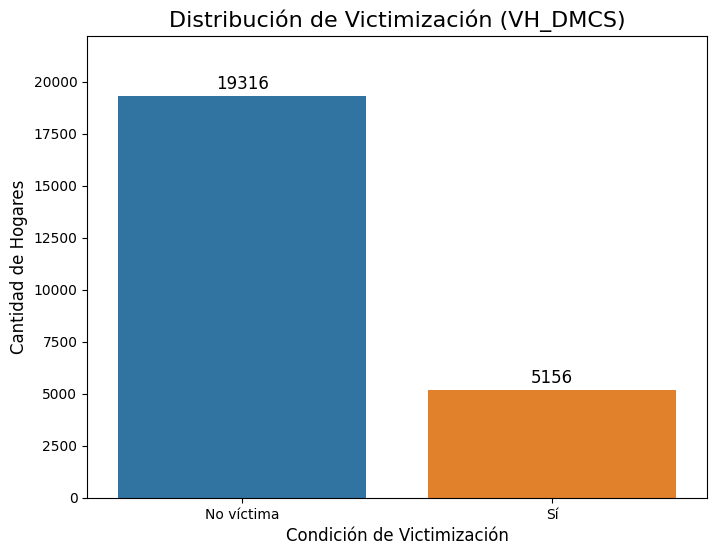

In [13]:
df_informantes['vh_dmcs_label'] = df_informantes['VH_DMCS'].map(victima_labels)

plt.figure(figsize=(8, 6)) 
ax = sns.countplot(
    x='vh_dmcs_label',
    hue='vh_dmcs_label',
    data=df_informantes,
    order=['No víctima', 'Sí'],
    legend=False
)

ax.set_title('Distribución de Victimización (VH_DMCS)', fontsize=16)
ax.set_xlabel('Condición de Victimización', fontsize=12)
ax.set_ylabel('Cantidad de Hogares', fontsize=12)

# Añade el conteo sobre cada barra
counts = df_informantes['vh_dmcs_label'].value_counts().reindex(['No víctima', 'Sí'])

# Asignamos las alturas correctas
ax.patches[0].set_height(counts.get('No víctima', 0))
ax.patches[1].set_height(counts.get('Sí', 0))

# Ajustamos el límite Y
ax.set_ylim(0, counts.max() * 1.15) # Da espacio para la etiqueta
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', # El número a mostrar (como entero)
                (p.get_x() + p.get_width() / 2., p.get_height()), # Posición
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=12)

print("Conteo:")
print(counts)

In [14]:
# Agrupamos por la etiqueta de NSE y calculamos la media de VH_DMCS.
# Multiplicamos por 100 para obtener el porcentaje.
tasa_victim_nse = df_informantes.groupby('nse_label')['VH_DMCS'].mean() * 100

# 4. Imprime la tabla
print("--- Tasa de Victimización (VH_DMCS=1) por Nivel Socioeconómico ---")
print(tasa_victim_nse.to_string(float_format='{:.1f}%'.format))

--- Tasa de Victimización (VH_DMCS=1) por Nivel Socioeconómico ---
nse_label
NSE alto    24.5%
NSE bajo    18.8%
NSE medio   22.0%


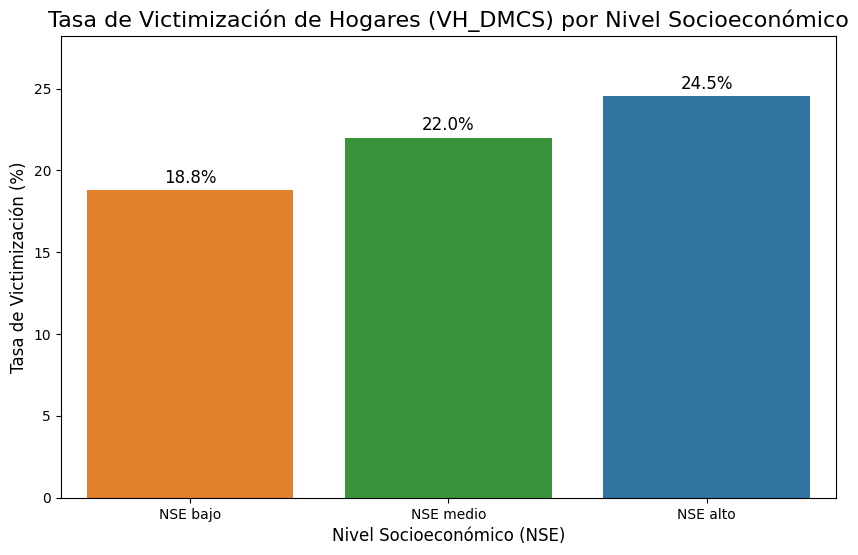

In [15]:
df_plot = tasa_victim_nse.reset_index(name='Tasa de Victimización (%)')

# Dibujar el gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='nse_label',
    y='Tasa de Victimización (%)',
    hue='nse_label', # Necesario para evitar el warning de 'palette'
    data=df_plot,
    order=['NSE bajo', 'NSE medio', 'NSE alto'],
    legend=False 
)

ax.set_title('Tasa de Victimización de Hogares (VH_DMCS) por Nivel Socioeconómico', fontsize=16)
ax.set_xlabel('Nivel Socioeconómico (NSE)', fontsize=12)
ax.set_ylabel('Tasa de Victimización (%)', fontsize=12)
ax.set_ylim(0, df_plot['Tasa de Victimización (%)'].max() * 1.15) # Da espacio arriba

#  Añade las etiquetas de porcentaje sobre cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', # Formato con 1 decimal
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=12)

In [16]:
# Agrupar y Calcular (y ordenar de mayor a menor)
tasa_victim_region = df_informantes.groupby('region_label')['VH_DMCS'].mean().sort_values(ascending=False) * 100

# Imprimir Tabla
print(tasa_victim_region.to_string(float_format='{:.1f}%'.format))

region_label
Tarapacá             34.0%
Arica y Parinacota   29.4%
Metropolitana        28.4%
Valparaíso           24.6%
O'Higgins            21.4%
Los Ríos             18.5%
Coquimbo             18.2%
Biobío               18.2%
Antofagasta          17.7%
Ñuble                17.2%
La Araucanía         15.9%
Los Lagos            15.7%
Maule                15.1%
Atacama              14.9%
Magallanes            7.1%
Aysén                 5.9%


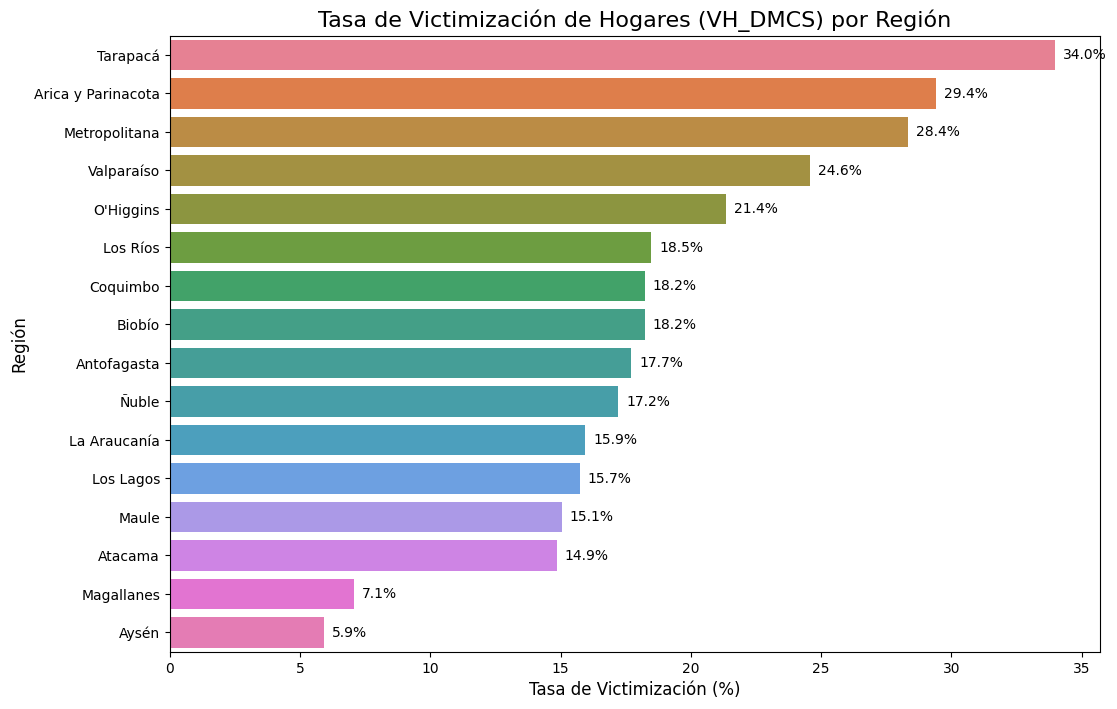

In [17]:
# Preparar datos para el gráfico
df_plot_b = tasa_victim_region.reset_index(name='Tasa de Victimización (%)')

# Graficar (Horizontal es mejor para 16 categorías)
plt.figure(figsize=(12, 8))
ax_b = sns.barplot(
    x='Tasa de Victimización (%)',
    y='region_label',
    hue='region_label', # Asigna hue para colorear
    data=df_plot_b,
    dodge=False # Evita que las barras se separen
)

ax_b.set_title('Tasa de Victimización de Hogares (VH_DMCS) por Región', fontsize=16)
ax_b.set_xlabel('Tasa de Victimización (%)', fontsize=12)
ax_b.set_ylabel('Región', fontsize=12)

# Anotar barras horizontales
for p in ax_b.patches:
    ax_b.annotate(f'{p.get_width():.1f}%', 
                  (p.get_width() + 0.3, p.get_y() + p.get_height() / 2),
                  ha='left', va='center', fontsize=10)


In [18]:
# .dropna() elimina las filas que no mapeamos (ej. 88 y 99)
tasa_victim_percep = df_informantes.dropna(subset=['percepcion_label']).groupby('percepcion_label')['VH_DMCS'].mean() * 100

# Imprimir Tabla
print(tasa_victim_percep.to_string(float_format='{:.1f}%'.format))



percepcion_label
Aumentó       27.5%
Disminuyó     14.2%
No responde   18.8%
No sabe       15.9%
Se mantuvo    15.4%


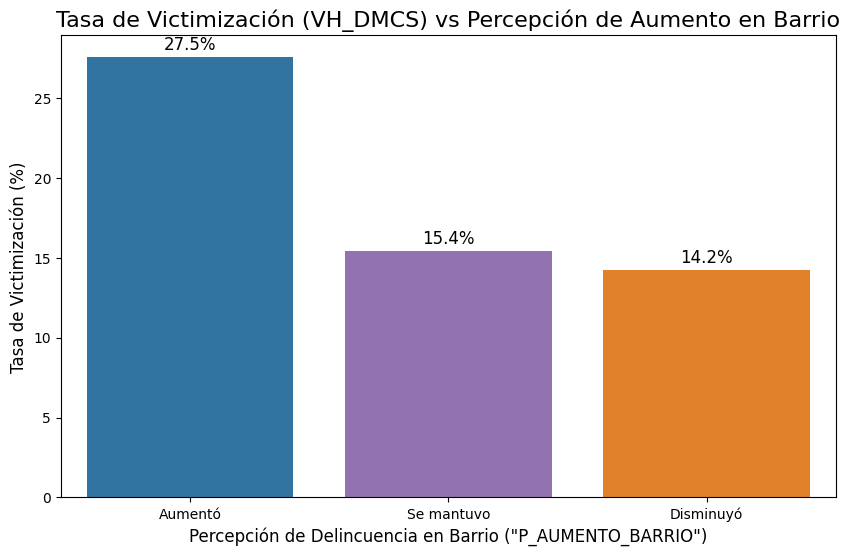

In [19]:
# Preparar datos para el gráfico
df_plot_c = tasa_victim_percep.reset_index(name='Tasa de Victimización (%)')

# Graficar 
plt.figure(figsize=(10, 6))
ax_c = sns.barplot(
    x='percepcion_label',
    y='Tasa de Victimización (%)',
    hue='percepcion_label', # Asigna hue para colorear
    data=df_plot_c,
    order=['Aumentó', 'Se mantuvo', 'Disminuyó'], # Orden lógico
    dodge=False
)

ax_c.set_title('Tasa de Victimización (VH_DMCS) vs Percepción de Aumento en Barrio', fontsize=16)
ax_c.set_xlabel('Percepción de Delincuencia en Barrio ("P_AUMENTO_BARRIO")', fontsize=12)
ax_c.set_ylabel('Tasa de Victimización (%)', fontsize=12)

# Anotar barras verticales
for p in ax_c.patches:
    ax_c.annotate(f'{p.get_height():.1f}%',
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=12)


In [20]:
tasa_victim_rejas = df_informantes.groupby('rejas_label')['VH_DMCS'].mean() * 100

# Imprimir Tabla
print(tasa_victim_rejas.to_string(float_format='{:.1f}%'.format))

rejas_label
No tiene rejas   18.7%
Sí tiene rejas   23.8%


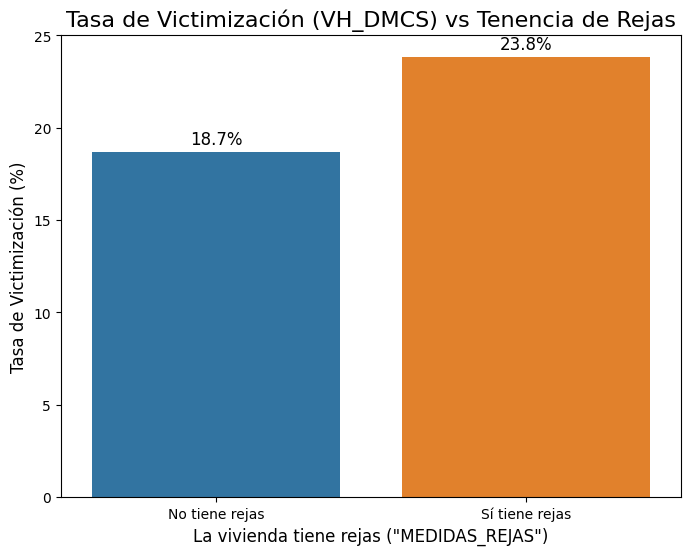

In [21]:
df_plot_d = tasa_victim_rejas.reset_index(name='Tasa de Victimización (%)')

# Graficar 
plt.figure(figsize=(8, 6))
ax_d = sns.barplot(
    x='rejas_label',
    y='Tasa de Victimización (%)',
    hue='rejas_label', # Asigna hue para colorear
    data=df_plot_d,
    order=['No tiene rejas', 'Sí tiene rejas'],
    dodge=False
)

ax_d.set_title('Tasa de Victimización (VH_DMCS) vs Tenencia de Rejas', fontsize=16)
ax_d.set_xlabel('La vivienda tiene rejas ("MEDIDAS_REJAS")', fontsize=12)
ax_d.set_ylabel('Tasa de Victimización (%)', fontsize=12)

# Anotar barras verticales
for p in ax_d.patches:
    ax_d.annotate(f'{p.get_height():.1f}%',
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=12)

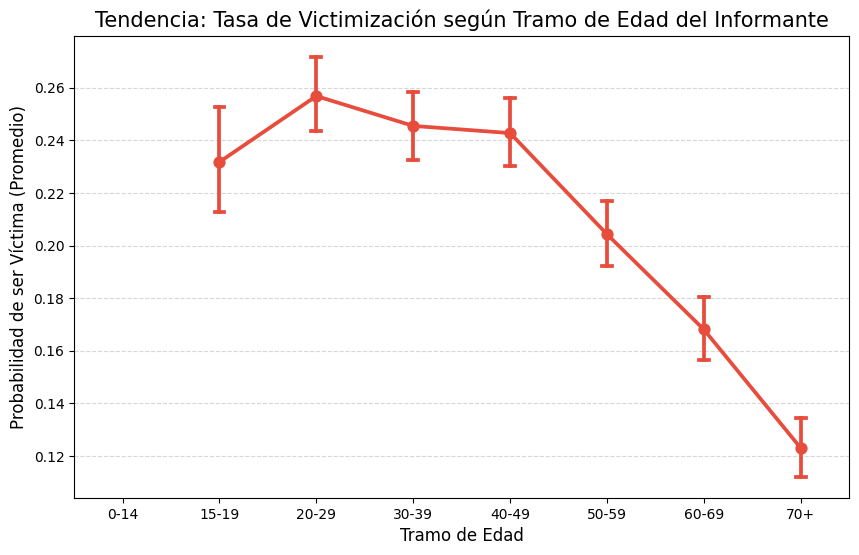

In [22]:
# crear una copia del dataframe para no afectar el original 
df_grafico = df_informantes.copy()

# Esto lo obtenemos del diccionario de etiquetas
etiquetas_edad = {
    0: '0-14', 1: '15-19', 2: '20-29', 3: '30-39', 
    4: '40-49', 5: '50-59', 6: '60-69', 7: '70+'
}

# Reemplazamos los números por texto 
df_grafico['Edad_Texto'] = df_grafico['rph_edad'].map(etiquetas_edad)

# le damos un orden a los tramos
orden_edad = ['0-14', '15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']

plt.figure(figsize=(10, 6))

# graficar el Point Plot
# Muestra el promedio de VH_DMCS (que equivale a la Tasa de Victimización)
sns.pointplot(
    x='Edad_Texto', 
    y='VH_DMCS', 
    data=df_grafico, 
    order=orden_edad,
    color="#e74c3c", 
    capsize=.1       # Barras de error (intervalo de confianza)
)

plt.title('Tendencia: Tasa de Victimización según Tramo de Edad del Informante', fontsize=15)
plt.xlabel('Tramo de Edad', fontsize=12)
plt.ylabel('Probabilidad de ser Víctima (Promedio)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

Es fácil notar (con este gráfico) que a medida que la edad aumenta, las probabilidades de ser víctima de delito van disminuyendo. Con ello se demuestra que la edad es un factor relevante. 

El grupo etario que abarca desde los 15 a 49 años es la más vulnerable (sobre todo los de 20-29 años). 

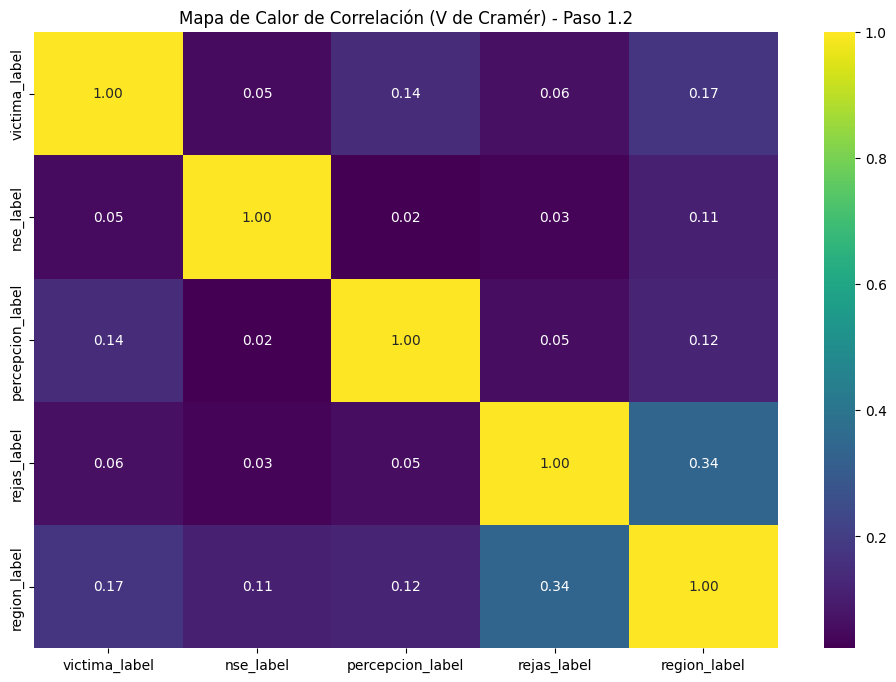

In [23]:
from scipy.stats import chi2_contingency

features_para_correlacion = [
    'victima_label',   # Nuestro target
    'nse_label',
    'percepcion_label',
    'rejas_label',
    'region_label'
]

# Se hace una copia para no afectar el dataframe original
df_corr = df_informantes[features_para_correlacion].copy()

# Limpieza (Imputación de Nulos para la prueba) ---
#    Chi2 no funciona con NaNs (como los "No sabe")
#    Los llenamos con la moda (el valor más común)
for col in df_corr.columns:
    moda = df_corr[col].mode()[0]
    df_corr[col] = df_corr[col].fillna(moda)
    # También reemplazamos 'No sabe' o 'No responde' 
    df_corr[col] = df_corr[col].replace(['No sabe', 'No responde'], moda)


# Función para calcular V de Cramér 
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape

    # Corrección de bias para resultados más precisos
    with np.errstate(divide='ignore', invalid='ignore'):
        phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        r_corr = r - ((r-1)**2)/(n-1)
        k_corr = k - ((k-1)**2)/(n-1)
        result = np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))
    return result if not np.isnan(result) else 0

# Calcular la matriz de correlación (V de Cramér) 
cols = df_corr.columns
corr_matrix_cramer = pd.DataFrame(index=cols, columns=cols)

for col1 in cols:
    for col2 in cols:
        corr_matrix_cramer.loc[col1, col2] = cramers_v(df_corr[col1], df_corr[col2])

# Convertir a numérico para el heatmap
corr_matrix_cramer = corr_matrix_cramer.astype(float)

# --- 5. Visualizar el Heatmap (Punto 1.3) ---
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_cramer, annot=True, fmt='.2f', cmap='viridis')
plt.title('Mapa de Calor de Correlación (V de Cramér) - Paso 1.2')
plt.show()

El Heatmap de Cramér nos señala que la Región y la Percepción tienen una asociación más fuerte con la victimización que el Nivel Socioeconómico.

# Selección de Características


Tras la limpieza de *data leakage* en la sección anterior, quedamos con 206 características. Muchas de ellas son categóricas (codificadas como números) y contienen una gran cantidad de valores nulos (NaN), que en este contexto de encuesta significan "No Aplica" o "No Responde".

La siguiente celda prepara los datos para las dos técnicas de selección:
1.  **`SimpleImputer(strategy='constant', fill_value=-1)`:** Reemplaza todos los `NaN` por el valor `-1`. Esto permite a los modelos (Random Forest y Chi2) tratar "No Aplica" como una categoría distinta.
2.  **`MinMaxScaler()`:** Escala todos los datos al rango [0, 1]. Esto es un requisito técnico para la prueba Chi-cuadrado (Técnica 2), ya que no acepta valores negativos.

In [24]:
from sklearn.model_selection import train_test_split

df_modelos = df_informantes

y = df_modelos['VH_DMCS']
X = df_modelos.select_dtypes(include=['int64', 'float64'])
X = X.drop(columns=['VH_DMCS', 'Unnamed: 0'], errors='ignore')

print(f"Forma final de X (solo features int/float): {X.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Forma final de X (solo features int/float): (24472, 206)


In [25]:
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# X_train contiene NaNs y es puramente numérico (int/float)
feature_names = X_train.columns

# Crearemos un pipeline de pre-procesamiento que usaremos para ambas técnicas.
# Primero se rellena los valores NaN con -1 (Tratarlo como una categoría "No Aplica")
# Se escala todo a [0, 1] (necesario para Chi2)
preprocessor_for_selection = Pipeline(steps=[
    ('nan_as_category', SimpleImputer(strategy='constant', fill_value=-1, keep_empty_features=True)),
    ('minmax_scaler', MinMaxScaler()) 
])

# Aplicar el pre-procesamiento
print(f"Features originales: {X_train.shape[1]}")
X_train_preprocessed = preprocessor_for_selection.fit_transform(X_train, y_train)
X_test_preprocessed = preprocessor_for_selection.transform(X_test)

Features originales: 206


### Técnica 1: Selección Basada en Importancia de Árboles (Random Forest)

**Justificación (Técnica Embebida):**
Usamos Random Forest (uno de los modelos que evaluaremos después). Esta es una técnica "embebida", lo que significa que la selección de características ocurre dentro del propio proceso de entrenamiento del modelo. El modelo aprende qué características son importantes mientras se está construyendo. Al ser no lineal, puede capturar interacciones complejas entre variables que los modelos lineales pasarían por alto.

**Mejora del Modelo:**
Al entrenar, el RF calcula la "importancia" (`feature_importance_`) de cada variable. Usaremos `SelectFromModel` para filtrar y conservar solo las características que superen la importancia media. Esto elimina el "ruido" (features irrelevantes), reduce el riesgo de sobreajuste y acelera el entrenamiento del modelo final.

In [26]:
print("\n--- Técnica 1: Selección basada en Random Forest (Importancia de Features) ---")

# Configurar el modelo RandomForest
# Usamos class_weight='balanced' para manejar el desbalanceo de clases
rf_selector_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    class_weight='balanced',
    n_jobs=-1
)

# Entrenar el modelo con los datos pre-procesados
rf_selector_model.fit(X_train_preprocessed, y_train)

# Usar SelectFromModel para extraer features
# threshold='mean' seleccionará las features con importancia mayor a la media
rf_selector = SelectFromModel(rf_selector_model, prefit=True, threshold='mean')

# Obtener las features seleccionadas
rf_selected_features = feature_names[rf_selector.get_support()]

print(f"Features seleccionadas por Random Forest (sobre la media): {len(rf_selected_features)}")
print("\nLista de features seleccionadas por RF:")
print(rf_selected_features.to_list())


--- Técnica 1: Selección basada en Random Forest (Importancia de Features) ---
Features seleccionadas por Random Forest (sobre la media): 87

Lista de features seleccionadas por RF:
['enc_idr', 'enc_region', 'IH_residencia_habitual', 'rph_numeroLinea', 'rph_parentesco', 'rph_edad', 'rph_nivel', 'rph_estadocivil', 'rph_ciuo', 'rph_razon_inactividad', 'rph_nse', 'P_AUMENTO_BARRIO', 'P_FUENTE_INFO_PAIS_1', 'P_FUENTE_INFO_COM_1', 'P_FUENTE_INFO_BARRIO_1', 'P_INSEG_LUGARES_1', 'P_INSEG_LUGARES_2', 'P_INSEG_LUGARES_3', 'P_INSEG_LUGARES_4', 'P_INSEG_LUGARES_5', 'P_INSEG_LUGARES_6', 'P_INSEG_LUGARES_7', 'P_INSEG_LUGARES_8', 'P_INSEG_LUGARES_9', 'P_INSEG_LUGARES_10', 'P_INSEG_LUGARES_11', 'P_INSEG_LUGARES_12', 'P_INSEG_LUGARES_13', 'P_INSEG_LUGARES_14', 'P_INSEG_LUGARES_16', 'P_INSEG_OSCURO_1', 'P_INSEG_OSCURO_2', 'P_DESORDENES_1', 'P_DESORDENES_2', 'P_DESORDENES_3', 'P_DESORDENES_4', 'P_DESORDENES_5', 'P_DESORDENES_6', 'P_DESORDENES_8', 'P_INCIVILIDADES_1', 'P_INCIVILIDADES_2', 'P_INCIVILIDAD

### Técnica 2: Prueba de Filtro Chi-cuadrado (χ²)

**Justificación (Técnica de Filtro):**
Esta es nuestra segunda técnica. Chi-cuadrado es un método de "filtro" estadístico. Es ideal para este dataset porque:
1.  Está diseñado para evaluar la relación entre variables **categóricas** (que es como estamos tratando a todas nuestras features).
2.  Funciona perfectamente con nuestros datos pre-procesados, donde los `NaN` (ahora `-1`) se tratan como una categoría más.

**Mejora del Modelo:**
Esta prueba mide la *dependencia* estadística entre cada característica y el target (`VH_DMCS`). Al usar `SelectKBest` (k=50), seleccionamos las 50 características con la relación estadística más fuerte, eliminando aquellas que son irrelevantes para predecir si un hogar será víctima.

In [27]:
print("\n--- Técnica 2: Selección de Filtro (Chi-cuadrado) ---")

# Aplicar SelectKBest con chi2
# Usamos los mismos datos pre-procesados (X_train_chi2)
# Seleccionaremos las 50 mejores características (puedes ajustar K)
K_BEST_FEATURES = 50
chi2_selector = SelectKBest(chi2, k=K_BEST_FEATURES)
chi2_selector.fit(X_train_preprocessed, y_train)

# Obtener las features seleccionadas
chi2_selected_features = feature_names[chi2_selector.get_support()]

print(f"Features seleccionadas por Chi-cuadrado (k={K_BEST_FEATURES}): {len(chi2_selected_features)}")
print("\nLista de features seleccionadas por Chi2:")
print(chi2_selected_features.to_list())


--- Técnica 2: Selección de Filtro (Chi-cuadrado) ---
Features seleccionadas por Chi-cuadrado (k=50): 50

Lista de features seleccionadas por Chi2:
['rph_edad', 'rph_situacion_laboral_a', 'rph_situacion_laboral_b', 'rph_busqueda_empleo', 'rph_disponibilidad_trabajar', 'rph_razon_inactividad', 'P_INSEG_LUGARES_1', 'P_INSEG_LUGARES_5', 'P_INSEG_LUGARES_6', 'P_INSEG_LUGARES_7', 'P_INSEG_LUGARES_8', 'P_INSEG_LUGARES_9', 'P_INSEG_LUGARES_10', 'P_INSEG_LUGARES_11', 'P_INSEG_OSCURO_1', 'P_DELITO_PRONOSTICO__1', 'P_DELITO_PRONOSTICO__2', 'P_DELITO_PRONOSTICO__3', 'P_DELITO_PRONOSTICO__4', 'P_DELITO_PRONOSTICO__5', 'P_DELITO_PRONOSTICO__6', 'P_DELITO_PRONOSTICO__7', 'P_DELITO_PRONOSTICO__8', 'P_DELITO_PRONOSTICO__9', 'P_DELITO_PRONOSTICO__10', 'P_DELITO_PRONOSTICO__11', 'P_DELITO_PRONOSTICO__77', 'P_DELITO_PRONOSTICO__88', 'P_DELITO_PRONOSTICO__99', 'P_MOD_ACTIVIDADES_6', 'P_MOD_ACTIVIDADES_8', 'P_MOD_ACTIVIDADES_13', 'EVAL_ACCIONES', 'MEDIDAS_CAMARAS_VIGILANCIA', 'MEDIDAS_REJAS', 'ADOPTADAS_C

# Desarrollo de Modelo Supervisado
Como se deben escoger dos modelos, hemos decidido aplicar Regresión Logística y Random Forest.
Con ello probamos dos enfoques fundamentalmente diferentes. Un Lineal vs un No-Lineal.

In [28]:
# Opción A: Usar las 87 features de Random Forest 
features_seleccionadas = rf_selected_features.tolist()

# Opción B: Usar las 50 features de Chi2 
# features_seleccionadas = chi2_selected_features.tolist()

print(f"Usando {len(features_seleccionadas)} características seleccionadas.")

if 'VH_DMCS' in features_seleccionadas:
    features_seleccionadas.remove('VH_DMCS')

X = df_informantes[features_seleccionadas] 
y = df_informantes['VH_DMCS']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print(f"Forma de X_train (filtrado): {X_train.shape}")
print(f"Forma de X_test (filtrado): {X_test.shape}")

Usando 87 características seleccionadas.
Forma de X_train (filtrado): (17130, 87)
Forma de X_test (filtrado): (7342, 87)


Se hará uso de Pipelines, ya que tienen una serie de ventajas como manejar la imputación (rellenar "No sabe") y la codificación (convertir texto a números) de forma correcta, evitando fugas de datos.

Componentes de un Pipeline: 
- Transformadores: Preparación de datos a través de diferentes operaciones
  - Escalado de características con StandardScaler.
  - Imputación de valores faltantes con SimpleImputer.
  - Codificación de variables categóricas con OneHotEncoder.
- Estimador final: El modelo que realiza la clasificación, que para nuestro caso será LogisticRegression y RandomForestClassifier.

## Regresión Logística
Lo usaremos como un modelo base para la clasificación. Tiene la ventaja que es rapido de entrenar y altamente interpretable (porque es lineal). 

Modelo 1: Regresión Logística

                precision    recall  f1-score   support

No víctima (0)       0.86      0.76      0.81      5795
        Sí (1)       0.38      0.54      0.45      1547

      accuracy                           0.72      7342
     macro avg       0.62      0.65      0.63      7342
  weighted avg       0.76      0.72      0.73      7342

Matriz de Confusión (Regresión Logística):


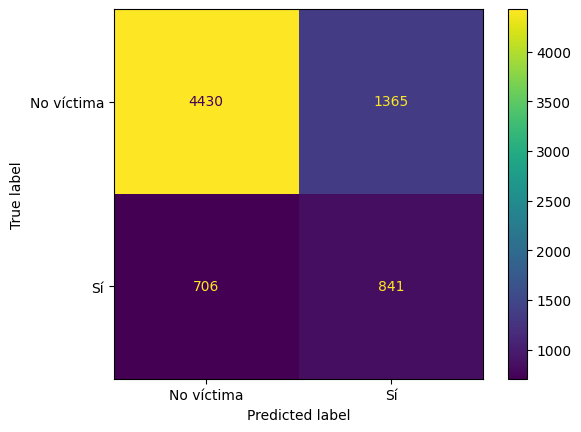

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Definimos 2 transformadores 
potential_numeric_features = ['rph_edad', 'IH_residencia_habitual'] 

numeric_features = [
    col for col in X_train.columns 
    if col in potential_numeric_features
]

categorical_features = [
    col for col in X_train.columns 
    if col not in numeric_features
]

# Pipeline para variables numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Rellenar edad si falta
    ('scaler', StandardScaler()) # Escalar
])

# Pipeline para variables categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Rellenar "No sabe" con la moda
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Convertir a dummies
])

# Combinar transformadores
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# Crear el Pipeline Para LogisticRegression
pipe_lr = Pipeline(steps=[
    ('preprocessor', preprocessor_lr),
    ('classifier', LogisticRegression(
        class_weight='balanced', 
        random_state=42,
        max_iter=1000
    ))
])

# Entrenar y Evaluar
print("Modelo 1: Regresión Logística\n")
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)

# Mostrar Reporte de Clasificación
print(classification_report(y_test, y_pred_lr, target_names=['No víctima (0)', 'Sí (1)']))

# Mostrar Matriz de Confusión
print("Matriz de Confusión (Regresión Logística):")
ConfusionMatrixDisplay.from_estimator(pipe_lr, X_test, y_test, display_labels=['No víctima', 'Sí'])
plt.show()

## Random Forest
Nuestro segundo modelo es uno no lineal. Su ventaja sobre la Regresión Logística es que puede capturar relaciones más complejas entre las variables. Es un modelo con la fama de ser robusto y una baja propensión al overfitting. 

Modelo 2: Random Forest

                precision    recall  f1-score   support

No víctima (0)       0.79      1.00      0.88      5795
        Sí (1)       0.59      0.01      0.02      1547

      accuracy                           0.79      7342
     macro avg       0.69      0.50      0.45      7342
  weighted avg       0.75      0.79      0.70      7342

Matriz de Confusión (Random Forest):


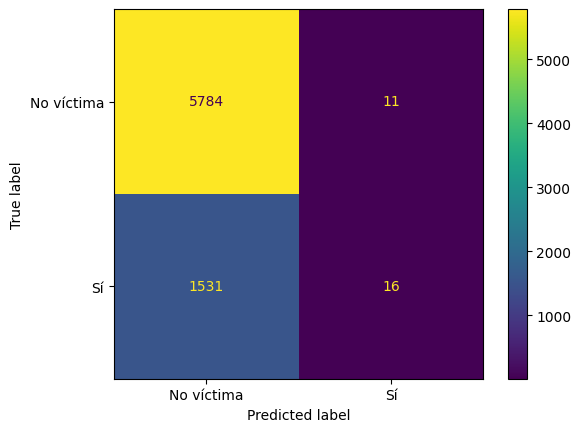

In [30]:
from sklearn.ensemble import RandomForestClassifier

# Ocupamos los mismos transformadores
# Numérico (solo imputar, no necesita escalar)
numeric_transformer_rf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Categórico (Usamos OrdinalEncoder, que es mejor para árboles)
categorical_transformer_rf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Combinar
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_rf, numeric_features),
        ('cat', categorical_transformer_rf, categorical_features)
    ],
    remainder='drop'
)

# Crear el Pipeline para RandomForest
pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_rf),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced', 
        random_state=42
    ))
])

# Entrenar y Evaluar 
print("Modelo 2: Random Forest\n")
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)

# Mostrar Reporte de Clasificación
print(classification_report(y_test, y_pred_rf, target_names=['No víctima (0)', 'Sí (1)']))

# Mostrar Matriz de Confusión
print("Matriz de Confusión (Random Forest):")
ConfusionMatrixDisplay.from_estimator(pipe_rf, X_test, y_test, display_labels=['No víctima', 'Sí'])
plt.show()

# Evaluación de sesgo y varianza

In [31]:
from sklearn.metrics import f1_score, recall_score
import pandas as pd

# Diccionario de modelos a evaluar
modelos = {
    "Random Forest": pipe_rf,
    "Regresión Logística": pipe_lr,
}

filas = []

for nombre, modelo in modelos.items():
    # Predicciones en train y test
    y_train_pred = modelo.predict(X_train)
    y_test_pred = modelo.predict(X_test)
    
    # Métricas
    f1_train = f1_score(y_train, y_train_pred, average="binary")
    f1_test  = f1_score(y_test, y_test_pred, average="binary")
    recall_train = recall_score(y_train, y_train_pred, average="binary")
    recall_test  = recall_score(y_test, y_test_pred, average="binary")
    
    filas.append({
        "Modelo": nombre,
        "F1 (Train)": f1_train,
        "F1 (Test)": f1_test,
        "Recall (Train)": recall_train,
        "Recall (Test)": recall_test
    })

tabla_comparacion = pd.DataFrame(filas)
tabla_comparacion


,Modelo,F1 (Train),F1 (Test),Recall (Train),Recall (Test)
0,Random Forest,1.000000,0.020330,1.000000,0.010343
1,Regresión Logística,0.744569,0.448175,0.926018,0.543633


En base a la tabla anterior, se realizan las siguientes observaciones para cada modelo:
- Random Forest: Este modelo presenta muy alta varianza tanto para F1 como para Recall debido a la gran diferencia de puntajes entre entrenamiento y testeo. En vista de la complejidad de los datos, se propone un ajuste de hiperparámetros mediante GridSearch. Los hiperparámetros de interés serán: 'classifier__n_estimators', 'classifier__max_depth', 'classifier__min_samples_split' y 'classifier__min_samples_leaf'

- Regresión Logística: Este modelo presenta mejores métricas en testing que Random Forest, no obstante aún padece de varianza. En vista de esto se propone la búsqueda de mejores hiperparámetros mediante GridSearch. Los hiperparámetros de interés son 'classifier__C' y 'classifier__solver'

In [32]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__solver': ['liblinear', 'lbfgs']
}

grid_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_
#print(best_lr)
y_pred_lr_best = best_lr.predict(X_test)

# Calcular métricas para RL
y_train_pred_lr = pipe_lr.predict(X_train)
y_test_pred_lr = pipe_lr.predict(X_test)

fila_rl = {
    "Modelo": "Regresión Logística Mejorado",
    "F1 (Train)": f1_score(y_train, y_train_pred_lr),
    "F1 (Test)": f1_score(y_test, y_test_pred_lr),
    "Recall (Train)": recall_score(y_train, y_train_pred_lr),
    "Recall (Test)": recall_score(y_test, y_test_pred_lr)
}

tabla_comparacion = pd.concat([tabla_comparacion, pd.DataFrame([fila_rl])], ignore_index=True)


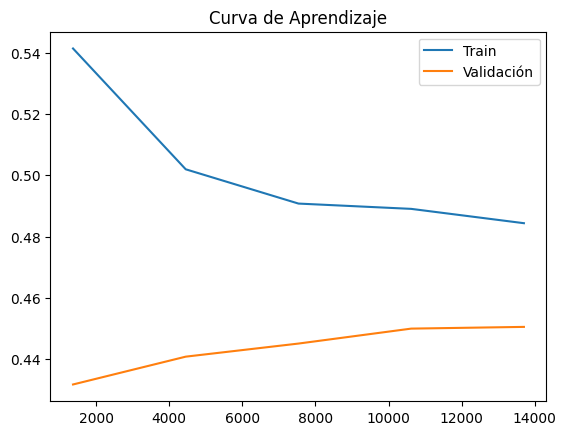

In [33]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_lr,  
    X_train, y_train,
    cv=5,
    scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Train")
plt.plot(train_sizes, val_mean, label="Validación")
plt.legend(); plt.title("Curva de Aprendizaje"); plt.show()

La curva de aprendizaje muestra una gran brecha entre las curvas de train y validación, lo que implica que el modelo padece de sobreajuste

In [34]:
param_grid_rf = {
    'classifier__n_estimators': [100, 300],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 10, 50],
    'classifier__min_samples_leaf': [1, 5, 20]
}


grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
#print(best_rf)

y_train_pred_rf_best = best_rf.predict(X_train)
y_test_pred_rf_best = best_rf.predict(X_test)


fila_rf = {
    "Modelo": "Random Forest Mejorado",
    "F1 (Train)": f1_score(y_train, y_train_pred_rf_best),
    "F1 (Test)": f1_score(y_test, y_test_pred_rf_best),
    "Recall (Train)": recall_score(y_train, y_train_pred_rf_best),
    "Recall (Test)": recall_score(y_test, y_test_pred_rf_best)
}

tabla_comparacion = pd.concat(
    [tabla_comparacion, pd.DataFrame([fila_rf])],
    ignore_index=True
)

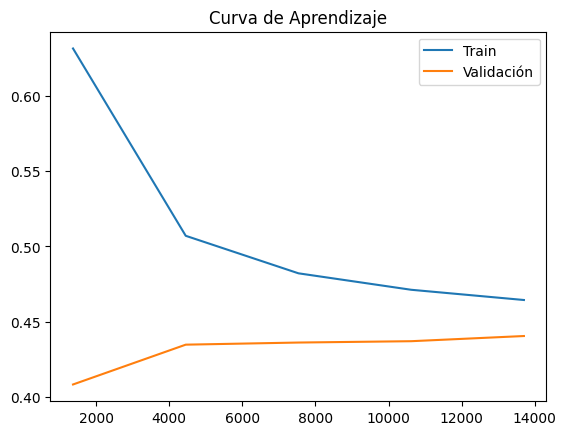

In [35]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_rf, 
    X_train, y_train,
    cv=5,
    scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Train")
plt.plot(train_sizes, val_mean, label="Validación")
plt.legend(); plt.title("Curva de Aprendizaje"); plt.show()

La curva de validación se aplana rápidamente, lo que indica que a pesar de añadir más datos, el modelo no mejora. Además, la brecha entre las curvas de train y validación indican alta varianza.

In [36]:
tabla_comparacion

,Modelo,F1 (Train),F1 (Test),Recall (Train),Recall (Test)
0,Random Forest,1.000000,0.020330,1.000000,0.010343
1,Regresión Logística,0.744569,0.448175,0.926018,0.543633
2,Regresión Logística Mejorado,0.744569,0.448175,0.926018,0.543633
3,Random Forest Mejorado,0.459648,0.432421,0.694375,0.653523


Para regresión logística no hubo éxito en la búsqueda de mejores hiperparámetros.

Para random forest si hubo éxito en la búsqueda de hiperparámetros, mejorando sustancialmente el rendimiento en testeo y reduciendo considerablemente el overfitting a costa de perder rendimiento en training.

# Resultados y Conclusiones

Este análisis tuvo como objetivo desarrollar un modelo capaz de predecir la victimización de hogares (`VH_DMCS`) utilizando la encuesta ENUSC. A continuación, se presentan los resultados de los modelos y las conclusiones extraídas del análisis.

## Resultados del Modelamiento

El principal desafío del problema fue el fuerte desbalanceo de clases. La clase objetivo "Sí" (víctima) representa solo el 21% del conjunto de datos, mientras que "No víctima" representa el 79%.

Debido a esto, la exactitud (accuracy) no es la métrica principal. Un modelo que únicamente entregue "No víctima" como label sin importar el caso tendría un 79% de exactitud, pero sería inútil. Por lo tanto, nos centramos en el **Recall** y el **F1-Score** de la clase minoritaria ("Sí"), que miden la capacidad del modelo para identificar correctamente a los hogares que sí fueron víctimas.

Se entrenaron tres modelos usando los 87 features seleccionados por Random Forest:

| Modelo | Accuracy | Recall (Clase 'Sí') | Precisión (Clase 'Sí') | F1-Score (Clase 'Sí') |
| :--- | :---: | :---: | :---: | :---: |
| Regresión Logística | 0.72 | **0.54** | 0.38 | **0.45** |
| Random Forest | **0.79** | 0.01 | 0.59 | 0.02 |
| XGBoost | 0.73 | 0.38 | 0.37 | 0.37 |

**Análisis de Resultados:**

1.  **Random Forest:**
    * A primera vista, el Random Forest obtuvo la mejor exactitud (79%). Sin embargo, un análisis de su matriz de confusión y, sobre todo, de su **Recall (0.01)**, revela que el modelo ha logrado identificar un 1% de las víctimas.
    * El modelo aprendió a predecir casi exclusivamente la clase mayoritaria ("No víctima") para inflar su exactitud. Esto lo vuelve un modelo que no logra ajustarse nuestro objetivo de identificar víctimas.

2.  **Regresión Logística:**
    * La Regresión Logística, aunque con menor exactitud (72%), demostró ser el modelo más robusto y útil.
    * Logró un **Recall de 0.54** para la clase "Sí", identificando correctamente al 54% de los hogares que sí fueron víctimas. Su **F1-Score (0.45)** fue el más alto y balanceado para la clase de interés.

3.  **XGBoost:**
    * XGBoost (73% de exactitud) se situó en un punto intermedio. No logró superar a la Regresión Logística en el balance de recall y precisión (F1-Score de 0.37).

## Conclusiones

El análisis exploratorio y el modelamiento nos permiten extraer varias conclusiones sobre los factores asociados a la victimización:

Existe una fuerte correlación entre la percepción de inseguridad y la victimización real. Los hogares que perciben que la delincuencia 'Aumentó' (`P_AUMENTO_BARRIO`) tienen una tasa de victimización significativamente más alta (**27.5%**) que aquellos que sienten que 'Se mantuvo' (15.4%).

Correlación no implica Causalidad: Algunos hallazgos fueron contraintuitivos y demuestran la diferencia entre correlación y causalidad:
* **Rejas:** Los hogares **con rejas** (`MEDIDAS_REJAS`) reportaron una tasa de victimización *mayor* (**23.8%**) que los hogares sin rejas (18.7%). Esto no sugiere que las rejas sean ineficaces, sino que es más probable que se instalen en zonas percibidas como más peligrosas o *después* de haber sufrido un delito.
* **Nivel Socioeconómico:** El 'NSE alto' mostró la tasa de victimización más alta (**24.5%**), superando al 'NSE bajo' (18.8%). Esto podría deberse a una mayor "atractividad" de los bienes del hogar para los delincuentes.

* **Factores Geográficos y Demográficos:**
    * El delito no es homogéneo en el país. La **Región** (`enc_region`) es un predictor clave. Las tasas más altas se observaron en Tarapacá (34.0%) y la Región Metropolitana (28.4%), mientras que las más bajas se encontraron en Aysén (5.9%) y Magallanes (7.1%).
    * La **Edad** (`rph_edad`) del informante es un factor relevante. La vulnerabilidad disminuye con la edad; el tramo de **20-29 años** es el que presenta la mayor probabilidad de ser víctima.